## To analyse the brain segmentation results

In [1]:
RUN_ID = 201
T1GD_SYNTH = True
MASK_CODE = 0 #RUN_ID - 80
if T1GD_SYNTH: MASK_CODE = 0
RANDOM_SEED = 0
ROOT_DIR = "/scratch1/sachinsa/brats_seg"
DATA_ROOT_DIR = "/scratch1/sachinsa/data"

In [2]:
import os
import matplotlib.pyplot as plt

import pdb
import numpy as np
import pickle
from utils.logger import Logger
from utils.plot import *
from itertools import chain, combinations

logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [3]:
load_dir = os.path.join(ROOT_DIR, f"run_{RUN_ID}")
fig_save_dir = os.path.join("..", "figs", f"run_{RUN_ID}")
os.makedirs(fig_save_dir, exist_ok=True)

In [4]:
with open(os.path.join(load_dir, 'training_info.pkl'), 'rb') as f:
    training_info = pickle.load(f)
    epoch_loss_values = training_info['epoch_loss_values']
    metric_values = training_info['metric_values']
    metric_values_tc = training_info['metric_values_tc']
    metric_values_wt = training_info['metric_values_wt']
    metric_values_et = training_info['metric_values_et']

In [5]:
max_epochs = len(epoch_loss_values)
val_interval = len(epoch_loss_values)//len(metric_values)
logger.info(f"Total epochs: {max_epochs}")

[INFO] Total epochs: 240


In [6]:
def all_subsets(arr):
    subsets = list(chain.from_iterable(combinations(arr, r) for r in range(0, len(arr))))
    return [list(subset) for subset in subsets]

mask_indices = all_subsets([0, 1, 2, 3])[MASK_CODE]
show_indices = [x for x in [0, 1, 2, 3] if x not in mask_indices]
channels = ["FLAIR", "T1w", "T1Gd", "T2w"]
label_list = ["TC", "WT", "ET"]

### Plot the loss and metric

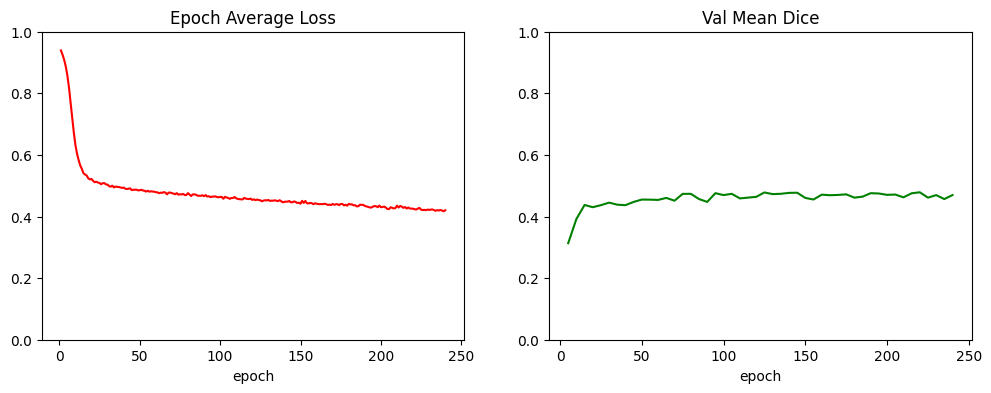

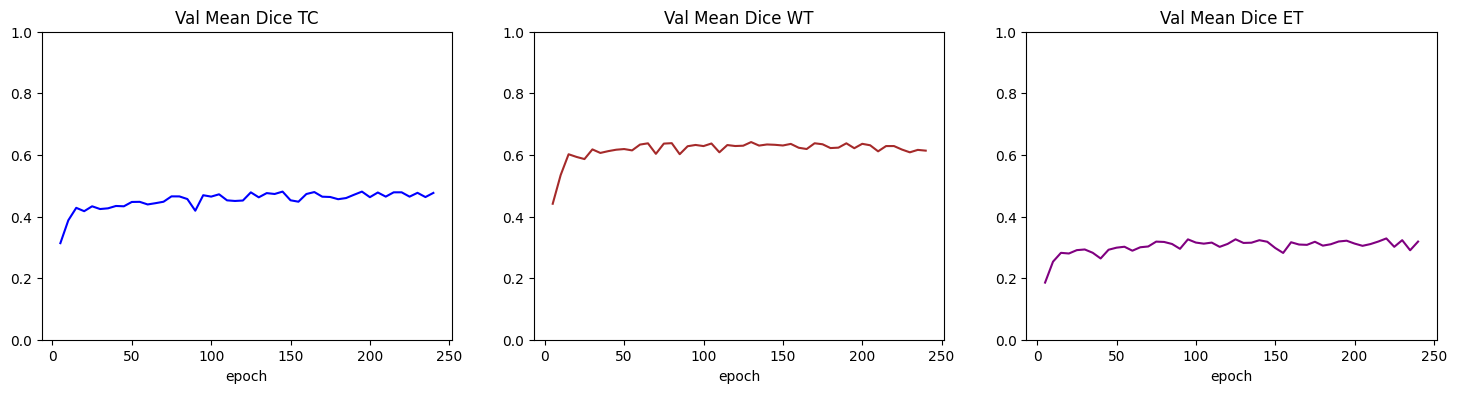

In [7]:
plot_training_tumor_seg(epoch_loss_values, metric_values, metric_values_tc, metric_values_wt, metric_values_et, val_interval)

Masked contrasts: []
Epochs  Total	TC	WT	ET
240	47.9	47.9	62.9	32.9


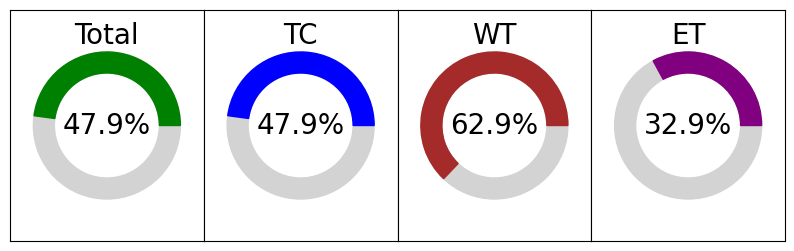

In [8]:
metric = np.max(metric_values)
arg_max = np.argmax(metric_values)
metric_tc = metric_values_tc[arg_max]
metric_wt = metric_values_wt[arg_max]
metric_et = metric_values_et[arg_max]

print(f"Masked contrasts: {[channels[i] for i in mask_indices]}")
print(f"Epochs  Total	TC	WT	ET")
print(f"{len(epoch_loss_values)}	{100*metric:.1f}	{100*metric_tc:.1f}	{100*metric_wt:.1f}	{100*metric_et:.1f}")


fig, axs = plt.subplots(1,4, figsize=(10, 3),gridspec_kw={'wspace': 0, 'hspace': 0})
plot_donut(metric, "Total", "green", axs[0])
plot_donut(metric_tc, "TC", "blue", axs[1])
plot_donut(metric_wt, "WT", "brown", axs[2])
plot_donut(metric_et, "ET", "purple", axs[3])
plt.show()



## Inference on the model

In [9]:
import torch
from monai.transforms import (
    Compose,
)
from monai.config import print_config
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
)
from monai.utils import set_determinism

from tqdm import tqdm
from utils.transforms import tumor_seg_transform as data_transform
from utils.model import create_SegResNet, inference
from utils.dataset import BraTSDataset

In [10]:
device = torch.device("cuda:0")
in_channels = len(show_indices)
model = create_SegResNet(in_channels, device)

In [11]:
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [12]:
# val_dataset = BraTSDataset(
#     version='2017',
#     load_t1gd = T1GD_SYNTH,
#     section = 'validation',
#     seed = RANDOM_SEED,
#     transform = data_transform['val']
# )


# temperarilty accessing all data
val_dataset = BraTSDataset(
    version='2017',
    load_t1gd = T1GD_SYNTH,
    section = 'all',
    seed = RANDOM_SEED,
    transform = data_transform['val']
)

In [13]:
checkpoint = torch.load(os.path.join(load_dir, 'best_checkpoint.pth'), weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [14]:
this_index = 0

In [15]:
id_ = 449 # np.sort(val_dataset.get_ids())[this_index]
this_index += 1
print(id_)

with torch.no_grad():
    this_input = val_dataset.get_with_id(id_)
    input_image = this_input["image"].unsqueeze(0).to(device)
    if not T1GD_SYNTH:
        input_image = input_image[:, show_indices, ...]
    input_label = this_input["label"]
    this_output = inference(input_image, model)
    this_output = post_trans(this_output[0])

449


In [16]:
def find_ratio_of_ones(tensor):
    total_elements = tensor.numel()
    count_ones = torch.sum(tensor)
    ratio = count_ones.float() / total_elements
    return ratio.item()

def tensor_to_sorted_tuple(tensor):
    unique_values, counts = torch.unique(tensor, return_counts=True)
    result = list(zip(unique_values.tolist(), counts.tolist()))
    result.sort(key=lambda x: x[1], reverse=True)
    return tuple(result)
    
def find_centroid_3d(tensor):
    print(f"TC: {find_ratio_of_ones(tensor)*100:.5f}%")
    indices = torch.nonzero(tensor, as_tuple=False)

    print(len(indices))
    print(tensor_to_sorted_tuple(indices[:, 2]))

    if indices.shape[0] == 0:
        shape = torch.tensor(tensor.shape, dtype=torch.float32)
        midpoint = (shape - 1) / 2
        return midpoint.round().to(torch.int64)

    centroid = torch.mean(indices.float(), dim=0).round().to(torch.int64)
    return centroid
    
label_centroid =  find_centroid_3d(input_label[0]) # centroid of TC (Tumor Core)
print(label_centroid)

TC: 0.80764%
72106
((88, 2151), (87, 2130), (90, 2124), (89, 2111), (86, 2067), (91, 2066), (84, 2053), (85, 2050), (83, 2048), (82, 2034), (81, 2024), (92, 2014), (80, 1989), (79, 1968), (78, 1949), (93, 1903), (77, 1899), (76, 1853), (94, 1848), (75, 1813), (95, 1808), (96, 1776), (74, 1762), (73, 1744), (97, 1725), (72, 1713), (98, 1667), (71, 1613), (99, 1560), (70, 1473), (100, 1408), (69, 1333), (101, 1325), (102, 1231), (103, 1079), (68, 1009), (104, 951), (105, 905), (67, 889), (66, 771), (106, 759), (107, 690), (65, 677), (108, 640), (64, 535), (63, 382), (109, 243), (62, 175), (110, 80), (61, 63), (60, 21), (111, 5))
metatensor([144, 154,  86])


/home1/sachinsa/.local/lib/python3.9/site-packages/torch/_tensor.py:1437: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  ret = func(*args, **kwargs)


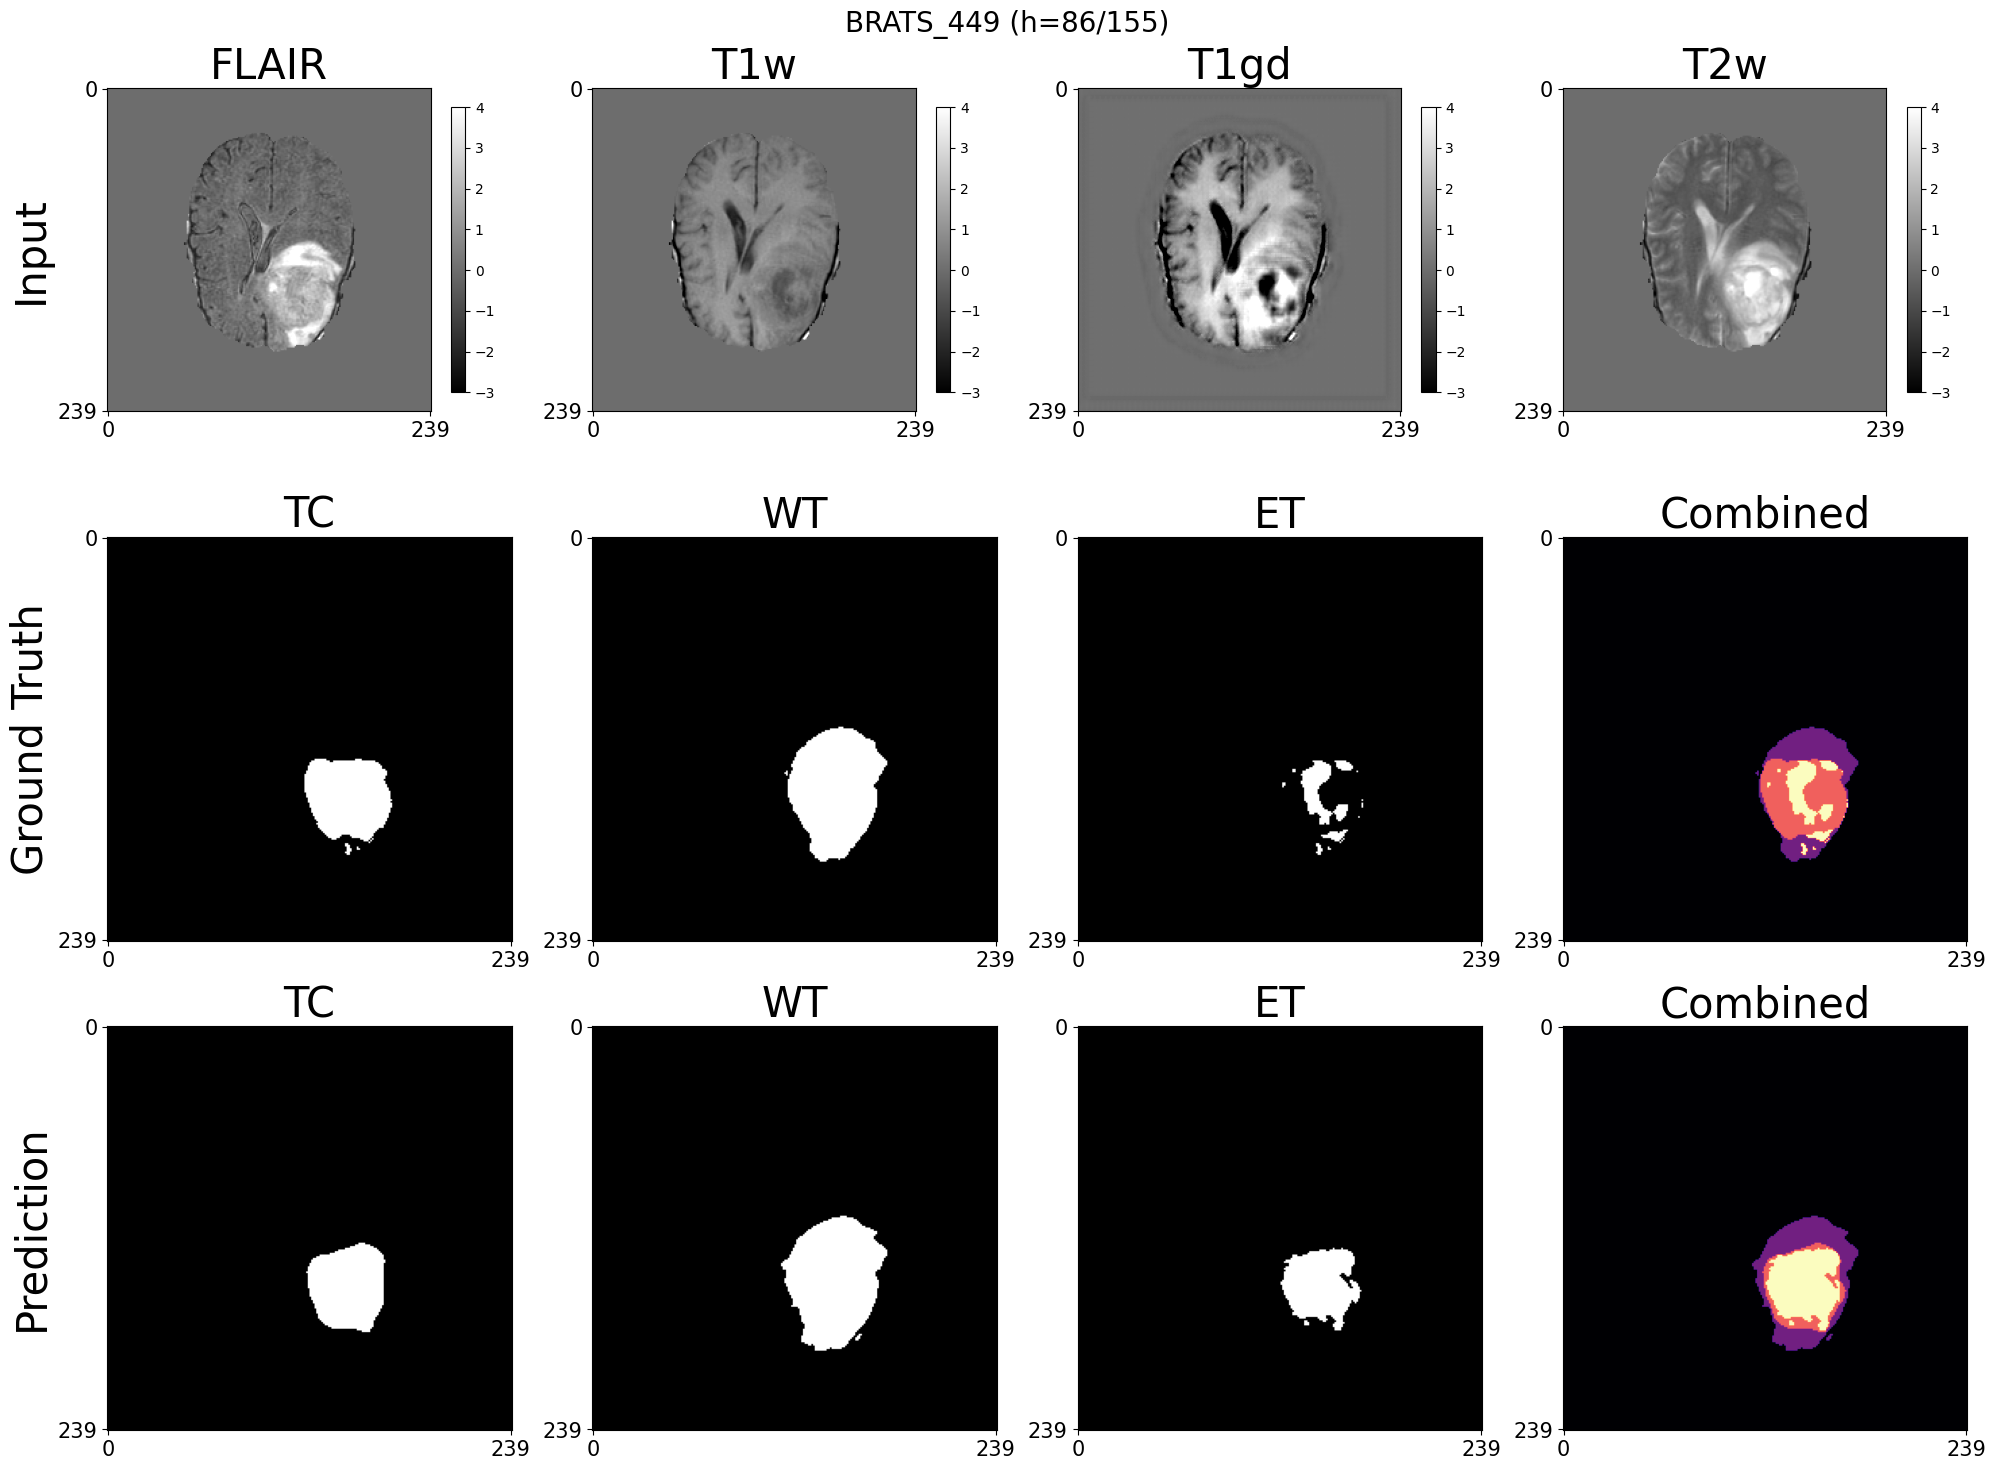

In [18]:
_, _, im_length, im_width, im_height = input_image.shape
h_index = label_centroid[-1]
label_list = ["TC", "WT", "ET", "Combined"]
channels = ["FLAIR", "T1w", "T1gd", "T2w"]

def plot_brain(index, label):
    if label == "ground_truth":
        start_index = 1*len(channels)
        brain_slice = input_label
        title = "Ground Truth"
    elif label == "prediction":
        start_index = 2*len(channels)
        brain_slice = this_output
        title = "Prediction"

    brain_slice = brain_slice[..., h_index].detach().cpu().T
    if index < 3:
        brain_slice = brain_slice[..., index]
    else:
        brain_slice = brain_slice.sum(axis=-1)
    plt.subplot(3, 4, start_index + index + 1)
    plt.title(label_list[index], fontsize=30)
    if index == 0:
        plt.ylabel(title, fontsize=30)
    plt.xticks([0, im_width - 1], [0, im_width - 1], fontsize=15)
    plt.yticks([0, im_length - 1], [0, im_length - 1], fontsize=15)
    cmap = "gray" if index < 3 else "magma"
    plt.imshow(brain_slice, cmap=cmap)


plt.figure("image", (24, 18))
for i in range(len(show_indices)):
    plt.subplot(3, 4, i + 1)
    plt.title(channels[show_indices[i]], fontsize=30)
    if i == 0:
        plt.ylabel("Input", fontsize=30)
    plt.xticks([0, im_width - 1], [0, im_width - 1], fontsize=15)
    plt.yticks([0, im_length - 1], [0, im_length - 1], fontsize=15)
    brain_slice = input_image[0, i, :, :, h_index].detach().cpu().T
    plt.imshow(brain_slice, cmap="gray", vmin=-3, vmax=4)
    plt.colorbar(shrink=0.7)
# plt.suptitle(f"BRATS_{this_input['id']} (h={h_index}/{im_height})", fontsize=20)
# plt.show()
    
# plt.figure("label", (18, 12))
for i in range(len(label_list)):
    plot_brain(i, "ground_truth")
for i in range(len(label_list)):
    plot_brain(i, "prediction")
plt.suptitle(f"BRATS_{this_input['id']} (h={h_index}/{im_height})", y=0.9, fontsize=20)
plt.show()